In [141]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Disable GPU (including MPS)

In [142]:
import tensorflow as tf
from keras import layers, models
from tensorflow_probability import distributions as tfd

class Net(tf.keras.Model):
    def __init__(self, img_stack):
        super(Net, self).__init__()
        self.cnn_base = models.Sequential([
            layers.Conv2D(8, kernel_size=4, strides=2, activation='relu', input_shape=(96, 96, img_stack)),
            layers.Conv2D(16, kernel_size=3, strides=2, activation='relu'),
            layers.Conv2D(32, kernel_size=3, strides=2, activation='relu'),
            layers.Conv2D(64, kernel_size=3, strides=2, activation='relu'),
            layers.Conv2D(128, kernel_size=3, strides=1, activation='relu'),
            layers.Conv2D(256, kernel_size=3, strides=1, activation='relu'),
            layers.Flatten()
        ])
        
        self.v = models.Sequential([
            layers.Dense(100, activation='relu'),
            layers.Dense(1)
        ])
        
        self.fc = models.Sequential([
            layers.Dense(100, activation='relu')
        ])
        
        self.alpha_head = layers.Dense(3, activation='softplus')
        self.beta_head = layers.Dense(3, activation='softplus')

    def call(self, inputs):
        x = self.cnn_base(inputs)
        v = self.v(x)
        x = self.fc(x)
        alpha = self.alpha_head(x) + 1
        beta = self.beta_head(x) + 1
        return (alpha, beta), v


In [143]:
import numpy as np
import gym
import tensorflow as tf
import time
import matplotlib
import matplotlib.pyplot as plt
from collections import deque

# Set device to GPU if available, otherwise fallback to CPU
device = tf.device("GPU" if tf.config.list_physical_devices('GPU') else "CPU")
print('device: ', device)

# Set random seeds for reproducibility
seed = 0
np.random.seed(seed)
tf.random.set_seed(seed)

# Initialize environment
action_repeat = 10
env = gym.make('CarRacing-v2', verbose=0)
state, _ = env.reset()  # Note that for Gym v0.26+, reset() returns a tuple (state, info)
print('env.action_space.shape: ', env.action_space.shape)
reward_threshold = env.spec.reward_threshold
print('reward_threshold:', reward_threshold)

# Example of rendering the environment (uncomment to visualize)
# plt.imshow(state)  # Visualize the first state (the initial observation)
# plt.show()



device:  <tensorflow.python.eager.context._EagerDeviceContext object at 0x34cb3fc80>
env.action_space.shape:  (3,)
reward_threshold: 900


frame.shape:  (96, 96, 3)
img.shape:  (96, 96)


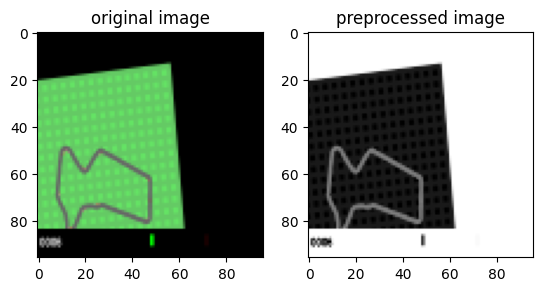

In [144]:
# show what a preprocessed image looks like
frame, _, _, _,_ = env.step(np.array([2., 1., 1.]))

print('frame.shape: ', frame.shape)
plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

#-------------------------------#

def rgb2gray(rgb, norm=True):
    # Convert RGB to grayscale using the standard formula
    gray = np.dot(rgb[..., :3], [0.299, 0.587, 0.114])  # RGB to grayscale
    if norm:
        # Normalize the grayscale image to range [-1, 1]
        gray = gray / 128.0 - 1.0
    return gray

img_gray = rgb2gray(frame)

#-------------------------------# 
plt.subplot(1,2,2)
plt.title('preprocessed image')

print('img.shape: ', img_gray.shape)

# 96 x 96 black and white image
plt.imshow(img_gray, cmap='Greys')
plt.show()

In [145]:
import numpy as np
import gym
import tensorflow as tf

class Wrapper:
    """
    Environment wrapper for CarRacing
    """

    def __init__(self, env, img_stack=4, action_repeat=4):
        self.env = env
        self.img_stack = img_stack
        self.action_repeat = action_repeat
        self.die = False
        self.stack = []
        self.av_r = self.reward_memory()

    def reset(self):
        self.counter = 0
        self.die = False
        img_rgb, _ = self.env.reset()  # Correct unpacking
        img_gray = rgb2gray(img_rgb)  # Convert to grayscale
        self.stack = [img_gray] * self.img_stack  # Stack the initial frames
        return np.array(self.stack)

    def step(self, action):
        total_reward = 0
        for _ in range(self.action_repeat):  # Loop for action repeats
            # Clip the action values as per environment specifications
            action[0] = np.clip(action[0], -1.0, 1.0)  # Steering (-1 to 1)
            action[1] = np.clip(action[1], 0.0, 1.0)   # Gas (0 to 1)
            action[2] = np.clip(action[2], 0.0, 1.0)   # Braking (0 to 1)
            
            # Step through the environment with the clipped action
            img_rgb, reward, done, truncated, info = self.env.step(action)

            # Apply penalties and rewards
            if self.die:
                reward += 100
            if np.mean(img_rgb[:, :, 1]) > 185.0:  # Green penalty
                reward -= 0.05

            total_reward += reward

            # Calculate rolling average reward to decide on episode termination
            done = True if self.av_r(reward) <= -0.1 else done
            if done or self.die:
                break

        # Convert the latest RGB image to grayscale and update the image stack
        img_gray = rgb2gray(img_rgb)
        self.stack.pop(0)  # Remove the oldest frame
        self.stack.append(img_gray)  # Add the new frame
        assert len(self.stack) == self.img_stack  # Ensure the stack size is correct

        return np.array(self.stack), total_reward, done, self.die

    @staticmethod
    def reward_memory():
        """
        Keeps track of the reward history for the last 100 steps.
        Returns a function that computes the rolling average reward.
        """
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            history[count] = reward
            count = (count + 1) % length
            return np.mean(history)

        return memory


In [146]:
import tensorflow as tf
import numpy as np
import gym
from tensorflow_probability import distributions as tfd


# Constants
GAMMA = 0.99
EPOCH = 8
MAX_SIZE = 2000  # CUDA out of mem for max_size=10000
BATCH = 128
EPS = 0.1
LEARNING_RATE = 0.001  # Better than 0.005 or 0.002
img_stack = 4

transition = np.dtype([('s', np.float64, (img_stack, 96, 96)), 
                       ('a', np.float64, (3,)), ('a_logp', np.float64),
                       ('r', np.float64), ('s_', np.float64, (img_stack, 96, 96))])

# class Agent:
#     """ Agent for training """

#     def __init__(self):
#         self.training_step = 0
#         self.net = Net(img_stack)  # No need for .to(device)
#         self.buffer = np.empty(MAX_SIZE, dtype=transition)
#         self.counter = 0
#         self.optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)


#     def select_action(self, state):
#     # Check and correct the state shape if necessary
#         state = tf.convert_to_tensor(state, dtype=tf.float64)
        
#         # Print the shape for debugging
#         print(state.shape)

#         # Ensure the correct shape (batch_size, height, width, channels)
#         if len(state.shape) == 4:  # (batch_size, channels, height, width)
#             state = tf.transpose(state, perm=[0, 2, 3, 1])  # (batch_size, height, width, channels)
#         elif len(state.shape) == 3:  # (batch_size, height, width, channels)
#             pass  # Already in the correct shape
#         else:
#             raise ValueError(f"Unexpected state shape: {state.shape}")

#         # Add batch dimension if missing (if state is not in (batch_size, height, width, channels))
#         state = tf.expand_dims(state, axis=0)  # Add batch dimension

#         # Select action using the model (e.g., policy network)
#         action, a_logp = self.policy_model(state)

#         return action, a_logp
    

#     # def select_action(self, state):
#     #     # Convert the state to a TensorFlow tensor
#     #     state = tf.convert_to_tensor(state, dtype=tf.float64)
        
#     #     # Reshape state to match expected input shape (batch_size, height, width, channels)
#     #     state = tf.transpose(state, perm=[0, 2, 3, 1])  # Change (batch_size, channels, height, width) to (batch_size, height, width, channels)
        
#     #     # Add batch dimension
#     #     state = tf.expand_dims(state, axis=0)  # Add batch dimension (1, 96, 96, 4)
        
#     #     # No gradient tracking for the inference phase
#     #     alpha, beta = self.net(state)[0]
        
#     #     # Use tf.stop_gradient to ensure no gradients are tracked
#     #     alpha = tf.stop_gradient(alpha)
#     #     beta = tf.stop_gradient(beta)
        
#     #     dist = tf.distributions.Beta(alpha, beta)
#     #     action = dist.sample()
#     #     a_logp = dist.log_prob(action)

#     #     action = action.numpy().squeeze()  # Convert to NumPy array for easy manipulation
#     #     a_logp = a_logp.numpy().item()    # Convert to NumPy scalar
#     #     return action, a_logp


#     def update(self):
#         self.training_step += 1
#         batch = np.random.choice(len(self.buffer), BATCH, replace=False)
#         states = np.array([self.buffer[idx][0] for idx in batch], dtype=np.float64)
#         actions = np.array([self.buffer[idx][1] for idx in batch], dtype=np.float64)
#         rewards = np.array([self.buffer[idx][3] for idx in batch], dtype=np.float64)
#         next_states = np.array([self.buffer[idx][4] for idx in batch], dtype=np.float64)
#         old_a_logp = np.array([self.buffer[idx][2] for idx in batch], dtype=np.float64)

#         states = tf.convert_to_tensor(states, dtype=tf.float64)
#         actions = tf.convert_to_tensor(actions, dtype=tf.float64)
#         rewards = tf.convert_to_tensor(rewards, dtype=tf.float64)
#         next_states = tf.convert_to_tensor(next_states, dtype=tf.float64)
#         old_a_logp = tf.convert_to_tensor(old_a_logp, dtype=tf.float64)

#         with tf.no_grad():
#             target_v = rewards + GAMMA * self.net(next_states)[1]
#             adv = target_v - self.net(states)[1]

#         for _ in range(EPOCH):
#             with tf.GradientTape() as tape:
#                 (alpha, beta), v = self.net(states)
#                 dist = tfd.Beta(alpha, beta)
#                 a_logp = dist.log_prob(actions).sum(axis=-1, keepdims=True)
#                 ratio = tf.exp(a_logp - old_a_logp)

#                 surr1 = ratio * adv
#                 surr2 = tf.clip_by_value(ratio, 1.0 - EPS, 1.0 + EPS) * adv

#                 action_loss = -tf.reduce_mean(tf.minimum(surr1, surr2))
#                 value_loss = tf.reduce_mean(tf.square(v - target_v))
#                 loss = action_loss + 2.0 * value_loss

#             grads = tape.gradient(loss, self.net.trainable_variables)
#             self.optimizer.apply_gradients(zip(grads, self.net.trainable_variables))


class Agent:
    def __init__(self):
        self.img_stack = img_stack
        self.device = device
        self.net = Net(img_stack)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        self.buffer = []
        self.counter = 0
        self.max_size = 2000

    def select_action(self, state):
        # Check the shape of the state to ensure it's correctly formatted
        if len(state.shape) == 3:  # If state is (img_stack, 96, 96)
            state = np.expand_dims(state, axis=0)  # Add batch dimension, resulting in (1, img_stack, 96, 96)

        # Convert state to TensorFlow tensor with dtype float32 (required for TensorFlow operations)
        state = tf.convert_to_tensor(state, dtype=tf.float32)

        # Reshape the state to ensure the correct shape (batch_size, height, width, channels)
        state = tf.transpose(state, perm=[0, 2, 3, 1])  # (1, img_stack, 96, 96) -> (1, 96, 96, img_stack)

        # Now state should have shape (None, 96, 96, 4)
        # Forward pass through the network
        (alpha, beta), _ = self.net(state)

        # Create Beta distribution
        dist = tfd.Beta(alpha, beta)

        # Sample an action and compute log probability
        action = dist.sample()
        a_logp = tf.reduce_sum(dist.log_prob(action), axis=-1)  # Sum across the action dimensions using tf.reduce_sum

        # Convert action and log probability to numpy arrays for further use
        action = action.numpy().squeeze()  # Remove extra dimensions
        a_logp = a_logp.numpy().item()  # Single value (log probability)

        return action, a_logp



    def store(self, transition):
        # Store transition in the buffer
        self.buffer.append(transition)
        if len(self.buffer) >= self.max_size:
            return True  # Buffer is full
        return False

    def update(self, gamma=0.99, epsilon=0.1, epochs=8, batch_size=128):
        """ Perform one update step """
        # Convert buffer to numpy arrays
        s = np.array([t[0] for t in self.buffer], dtype=np.float64)  # States
        a = np.array([t[1] for t in self.buffer], dtype=np.float64)  # Actions
        r = np.array([t[3] for t in self.buffer], dtype=np.float64)  # Rewards
        next_s = np.array([t[4] for t in self.buffer], dtype=np.float64)  # Next states
        old_a_logp = np.array([t[2] for t in self.buffer], dtype=np.float64)  # Log probabilities

        # Convert arrays to tensors
        s = tf.convert_to_tensor(s, dtype=tf.float64)
        a = tf.convert_to_tensor(a, dtype=tf.float64)
        r = tf.convert_to_tensor(r, dtype=tf.float64)
        next_s = tf.convert_to_tensor(next_s, dtype=tf.float64)
        old_a_logp = tf.convert_to_tensor(old_a_logp, dtype=tf.float64)

        # Compute the target value V(s) using the value network
        (_, _), target_v = self.net(next_s)
        target_v = r + gamma * target_v

        # Compute the advantage (A(s, a)) = target_v - V(s)
        (_, _), v = self.net(s)
        adv = target_v - v

        # Normalize the advantage (optional, for stability)
        adv = (adv - tf.reduce_mean(adv)) / (tf.reduce_std(adv) + 1e-8)

        # Perform PPO update
        for epoch in range(epochs):
            for batch_start in range(0, len(self.buffer), batch_size):
                batch_end = min(batch_start + batch_size, len(self.buffer))
                batch_indices = np.arange(batch_start, batch_end)

                # Get batch of data
                batch_s = s[batch_indices]
                batch_a = a[batch_indices]
                batch_r = r[batch_indices]
                batch_old_a_logp = old_a_logp[batch_indices]
                batch_adv = adv[batch_indices]

                # Forward pass through the network
                (alpha, beta), value = self.net(batch_s)

                # Create the Beta distribution and compute the log probability of actions
                dist = tfd.Beta(alpha, beta)
                a_logp = dist.log_prob(batch_a).sum(axis=-1, keepdims=True)

                # Compute the ratio of new and old log probabilities
                ratio = tf.exp(a_logp - batch_old_a_logp)

                # Compute the clipped surrogate objective
                surr1 = ratio * batch_adv
                surr2 = tf.clip_by_value(ratio, 1 - epsilon, 1 + epsilon) * batch_adv
                action_loss = -tf.reduce_mean(tf.minimum(surr1, surr2))

                # Value loss
                value_loss = tf.reduce_mean(tf.square(value - batch_r))

                # Total loss
                loss = action_loss + 0.5 * value_loss  # Total loss = action loss + value loss

                # Compute gradients and update the model
                self.optimizer.minimize(loss, var_list=self.net.trainable_variables)

        # Clear buffer after update
        self.buffer = []

In [147]:
def save(agent, path, suffix):
    # Assuming the function saves the model with a suffix to distinguish different versions
    model_path = f"{path}_{suffix}.h5"
    agent.net.save(model_path)  # Save model weights to the file

In [148]:
agent = Agent()

env_wrap = Wrapper(env)

limits = [200, 400, 600, 800, 830, 870, 900]

# def ppo_train(n_episodes=5, save_every=500):
#     scores_deque = deque(maxlen=100)
#     scores_array = []
#     avg_scores_array = []
#     timestep_after_last_save = 0
#     time_start = time.time()
#     running_score = 0
#     state = env_wrap.reset()
    
#     for i_episode in range(n_episodes):
#         timestep = 0
#         total_reward = 0
#         state = env_wrap.reset()

#         while True:
#             action, a_logp = agent.select_action(state)
#             next_state, reward, done, die = env_wrap.step(
#                 action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.])
#             )

#             if agent.store((state, action, a_logp, reward, next_state)):
#                 print('updating')
#                 agent.update()

#             total_reward += reward
#             state = next_state
#             timestep += 1  
#             timestep_after_last_save += 1

#             if done or die:
#                 break

#         running_score = running_score * 0.99 + total_reward * 0.01
#         scores_deque.append(total_reward)
#         scores_array.append(total_reward)

#         avg_score = np.mean(scores_deque)
#         avg_scores_array.append(avg_score)

#         s = int(time.time() - time_start)
#         print(f'Ep. {i_episode}, Ep.Timesteps {timestep}, Score: {total_reward:.2f}, Avg.Score: {avg_score:.2f}, Run.Score {running_score:.2f}, Time: {s//3600}:{(s%3600)//60}:{s%60}')

#         # Save episode if more than save_every timesteps
#         if timestep_after_last_save >= save_every:
#             timestep_after_last_save %= save_every
#             save(agent, '/path/to/save/model', 'model_weights')

#         if np.mean(scores_deque) > reward_threshold:
#             print(f"Solved environment! Running score is {running_score:.2f}, Avg.Score: {avg_score:.2f}")
#             break

#     return scores_array, avg_scores_array
def ppo_train(n_episodes=5, save_every_episodes=50):
    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []
    timestep_after_last_save = 0
    time_start = time.time()
    running_score = 0
    state = env_wrap.reset()
    
    for i_episode in range(n_episodes):
        timestep = 0
        total_reward = 0
        state = env_wrap.reset()

        while True:
            action, a_logp = agent.select_action(state)
            next_state, reward, done, die = env_wrap.step(
                action * np.array([2., 1., 1.]) + np.array([-1., 0., 0.])
            )

            if agent.store((state, action, a_logp, reward, next_state)):
                print('updating')
                agent.update()

            total_reward += reward
            state = next_state
            timestep += 1  
            timestep_after_last_save += 1

            if done or die:
                break

        running_score = running_score * 0.99 + total_reward * 0.01
        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        s = int(time.time() - time_start)
        print(f'Ep. {i_episode}, Ep.Timesteps {timestep}, Score: {total_reward:.2f}, Avg.Score: {avg_score:.2f}, Run.Score {running_score:.2f}, Time: {s//3600}:{(s%3600)//60}:{s%60}')

        # Save model every `save_every_episodes` episodes
        if (i_episode + 1) % save_every_episodes == 0:
            save(agent, '/path/to/save/model', suffix=f'model_weights_ep_{i_episode + 1}')

        # Check if we have solved the environment
        if np.mean(scores_deque) > reward_threshold:
            print(f"Solved environment! Running score is {running_score:.2f}, Avg.Score: {avg_score:.2f}")
            break

    return scores_array, avg_scores_array


In [149]:
scores, avg_scores  = ppo_train()     

2024-11-21 15:58:43.583174: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-21 15:58:43.591620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-21 15:58:43.624545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-11-21 15:58:43.663384: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-21 15:58:43.668747: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-21 15:58:43.676211: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-21 15:58:43.72

Ep. 0, Ep.Timesteps 247, Score: -17.91, Avg.Score: -17.91, Run.Score -0.18, Time: 0:0:10


2024-11-21 15:58:53.652746: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-21 15:58:53.654425: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-21 15:58:53.654907: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-21 15:58:53.655306: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-21 15:58:53.659653: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation.
2024-11-21 15:58:53.660023: I metal_plugin/src/kernels/stateless_random_op.cc:282] Note the GPU implementation does not produce the same series as CPU implementation

KeyboardInterrupt: 